In [1]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import statsmodels.api as sm
from scipy import stats

/Users/karlaruggaber/Desktop/HSG/Semester3/Statistik für Data Science/Projekt/Statistik-Datenbank/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")


Echter Mittelwert des gesamten Datensatzes: 70.35 USD
Bootstrap-Schätzung des Mittelwerts:       70.41 USD
95%-Konfidenzintervall:                   [62.57, 80.99]


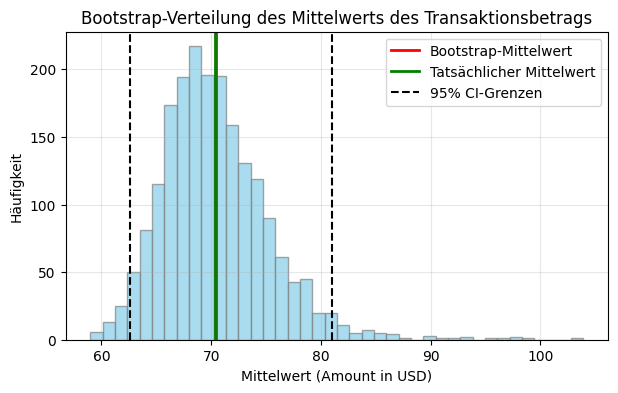

In [7]:
import numpy as np

# === Parameter ===============================================================
n_boot = 2000      # Anzahl Bootstrap-Stichproben
n_sample = 1000    # Größe jeder Stichprobe (kann < len(ds) sein)
col = "amt"        # Variable, deren Mittelwert wir schätzen

# === ECHTER Mittelwert =======================================================
true_mean = ds[col].mean()

# === Bootstrap-Schleife ======================================================
means = []
for i in range(n_boot):
    sample = ds[col].sample(n=n_sample, replace=True)
    means.append(sample.mean())

means = np.array(means)

# === Bootstrap-Ergebnisse ====================================================
boot_mean = np.mean(means)
ci_lower = np.percentile(means, 2.5)
ci_upper = np.percentile(means, 97.5)

# === Ausgabe ================================================================
print(f"Echter Mittelwert des gesamten Datensatzes: {true_mean:,.2f} USD")
print(f"Bootstrap-Schätzung des Mittelwerts:       {boot_mean:,.2f} USD")
print(f"95%-Konfidenzintervall:                   [{ci_lower:,.2f}, {ci_upper:,.2f}]")

# === Visualisierung ==========================================================
plt.figure(figsize=(7,4))
plt.hist(means, bins=40, color="skyblue", edgecolor="gray", alpha=0.7)
plt.axvline(boot_mean, color="red", linewidth=2, label="Bootstrap-Mittelwert")
plt.axvline(true_mean, color="green", linewidth=2, label="Tatsächlicher Mittelwert")
plt.axvline(ci_lower, color="black", linestyle="--", label="95% CI-Grenzen")
plt.axvline(ci_upper, color="black", linestyle="--")
plt.title("Bootstrap-Verteilung des Mittelwerts des Transaktionsbetrags")
plt.xlabel("Mittelwert (Amount in USD)")
plt.ylabel("Häufigkeit")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Betrugsrate (is_fraud): 0.005789
95%-Wald-Konfidenzintervall: [0.005658, 0.005919]


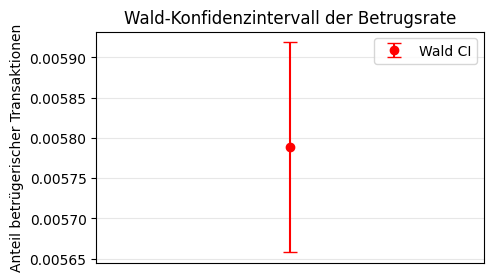

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# === Parameter ===============================================================
col = "is_fraud"
n = len(ds)
p_hat = ds[col].mean()
z = norm.ppf(0.975)  # z-Wert für 95%-Konfidenzintervall (alpha = 0.05)

# === Wald-Konfidenzintervall =================================================
se = np.sqrt(p_hat * (1 - p_hat) / n)  # Standardfehler
ci_lower = p_hat - z * se
ci_upper = p_hat + z * se

print(f"Betrugsrate (is_fraud): {p_hat:.6f}")
print(f"95%-Wald-Konfidenzintervall: [{ci_lower:.6f}, {ci_upper:.6f}]")

# === Visualisierung ==========================================================
plt.figure(figsize=(5,3))
plt.errorbar(x=0, y=p_hat, yerr=z*se, fmt='o', color='red', capsize=5, label='Wald CI')
plt.xlim(-1, 1)
plt.title("Wald-Konfidenzintervall der Betrugsrate")
plt.ylabel("Anteil betrügerischer Transaktionen")
plt.xticks([])
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()